# **Paso 1: Evaluación del modelo binario**

Found 1732 images belonging to 2 classes.
Total de imágenes en el conjunto de prueba: 1732
55/55 [==============================] - 45s 800ms/step - loss: 0.6081 - accuracy: 0.8938 - precision_1: 0.8672 - recall_1: 0.8769 - auc_1: 0.9324

Resultados de evaluación en el conjunto de prueba:
Precisión (Accuracy): 0.8938
Recall: 0.8769
Precision: 0.8672
AUC: 0.9324
55/55 [==============================] - 44s 795ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

   No Lesion       0.91      0.91      0.91      1017
      Lesion       0.87      0.88      0.87       715

    accuracy                           0.89      1732
   macro avg       0.89      0.89      0.89      1732
weighted avg       0.89      0.89      0.89      1732



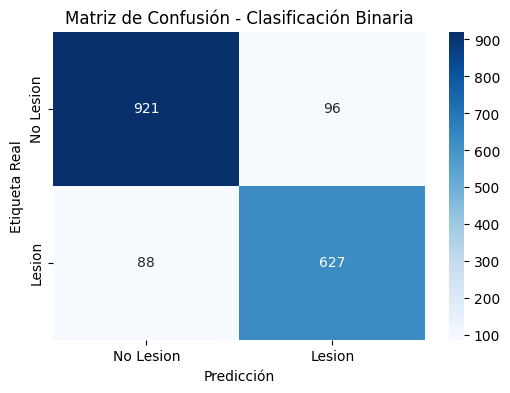

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo binario
binary_model = tf.keras.models.load_model('modelosFinales/xceptionNet_clasificacionBinaria_aug.keras', compile=False)
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Directorio de prueba
test_dir = 'crops/test'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']  # Usar las clases correspondientes
)

# Verificar cantidad de imágenes en el conjunto de prueba
print(f"Total de imágenes en el conjunto de prueba: {test_generator.samples}")

# Evaluar el modelo binario en el conjunto de prueba
evaluation_metrics = binary_model.evaluate(test_generator)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics

print("\nResultados de evaluación en el conjunto de prueba:")
print(f"Precisión (Accuracy): {test_acc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"AUC: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = binary_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes  # Etiquetas reales del generador

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Lesion', 'Lesion']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# **Paso 2: Evaluación del modelo de clasificación multicategoría**

Found 715 images belonging to 5 classes.
23/23 [==============================] - 19s 803ms/step


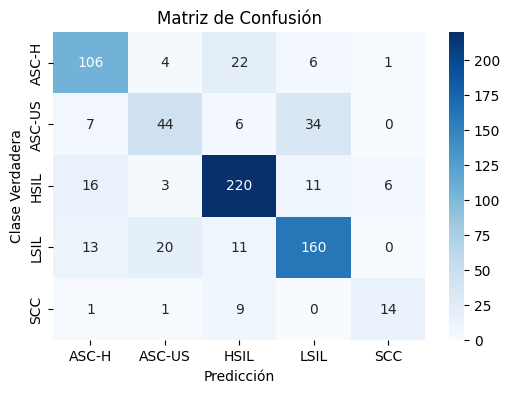

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo binario
five_classes_model = tf.keras.models.load_model('modelosFinales/xception_clasificacion5clases_aug.keras', custom_objects={'Functional': tf.keras.models.Model}, compile=False)
five_classes_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',  # Pérdida para multiclase
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Directorio de prueba
test_dir = 'crops/test/1_lesion'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Solo subcarpeta de lesiones
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy, test_precision, test_recall, test_auc = five_classes_model.evaluate(test_generator)

# Realizar predicciones en el conjunto de prueba
test_steps = np.ceil(test_generator.samples / test_generator.batch_size)
predictions = five_classes_model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()

23/23 [==============================] - 20s 867ms/step


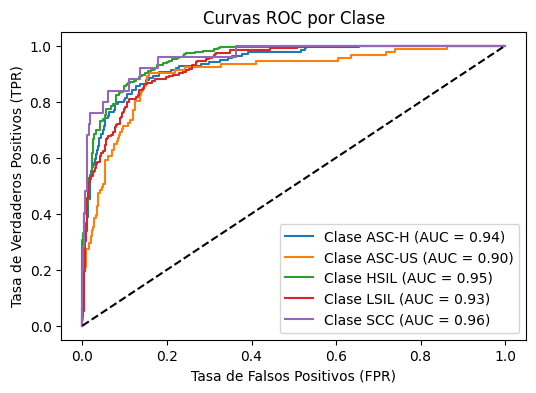

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.94


In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = five_classes_model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(6, 4))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

#  **Paso 3: Pipeline**

Found 1732 images belonging to 2 classes.
55/55 [==============================] - 48s 858ms/step


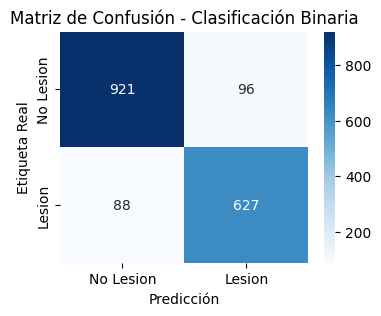

1/1 [==============================] - 0s 75ms/step


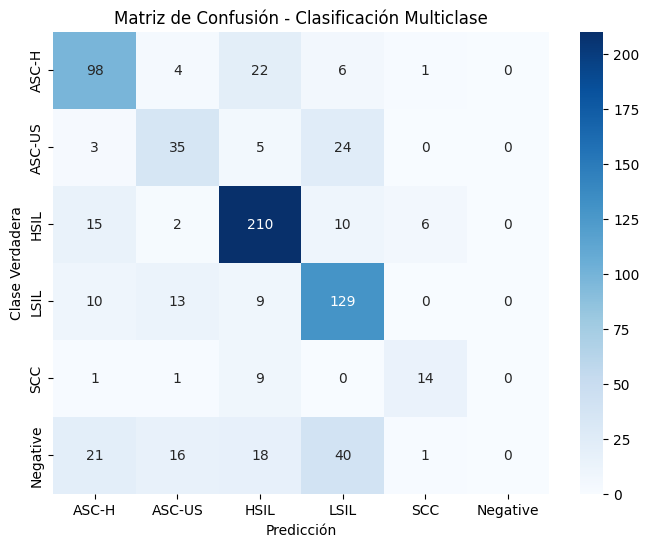

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar modelos
binary_model = tf.keras.models.load_model('modelosFinales/xceptionNet_clasificacionBinaria_aug.keras', compile=False)
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


five_classes_model = tf.keras.models.load_model('modelosFinales/xception_clasificacion5clases_aug.keras', custom_objects={'Functional': tf.keras.models.Model}, compile=False)
five_classes_model.compile(optimizer=Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',  # Pérdida para multiclase
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Directorio de prueba
test_dir = 'crops/test'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']
)

# Paso 1: Evaluar y clasificar usando el modelo binario
binary_predictions = (binary_model.predict(test_generator) > 0.5).astype(int).flatten()
y_true_binary = test_generator.classes


# Matriz de confusión
cm = confusion_matrix(y_true_binary, binary_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Crear un DataFrame para almacenar las predicciones y las rutas de archivos
binary_results_df = pd.DataFrame({
    'filepath': test_generator.filepaths,
    'true_label': y_true_binary,
    'predicted_label': binary_predictions
})

# Filtrar imágenes clasificadas como "Lesión" por el modelo binario para pasar al modelo multiclase
lesion_image_paths = binary_results_df[binary_results_df['predicted_label'] == 1]['filepath'].values

# Paso 2: Clasificar imágenes de "lesión" con el modelo de 5 clases

# Preparación para evaluación multiclase
y_true_multi = []
y_pred_multi = []

# Configurar la dimensión esperada del modelo multiclase
IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI = 224, 224  # Asegurarse de que coincida con la configuración del modelo
lesion_classes = class_labels + ['Negative'] # Ajusta estas clases según tu modelo

# Paso 2: Evaluación multiclase con las imágenes clasificadas como "lesión"
for img_path in lesion_image_paths:
    # Obtener la clase verdadera desde el path de la imagen
    true_class_name = os.path.basename(os.path.dirname(img_path))

    # Procesar la imagen para el modelo de 5 clases
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción y almacenar los resultados
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Obtener el índice de la clase verdadera en `lesion_classes`
    true_class_index = lesion_classes.index(true_class_name)  # Busca el índice en la lista `lesion_classes`
    y_true_multi.append(true_class_index)
    y_pred_multi.append(predicted_class)

# Crear la matriz de confusión segundo paso
cm = confusion_matrix(y_true_multi, y_pred_multi)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes)
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión - Clasificación Multiclase')
plt.show()



**Matriz de confusión final con escala original**

1/1 [==============================] - 0s 59ms/step


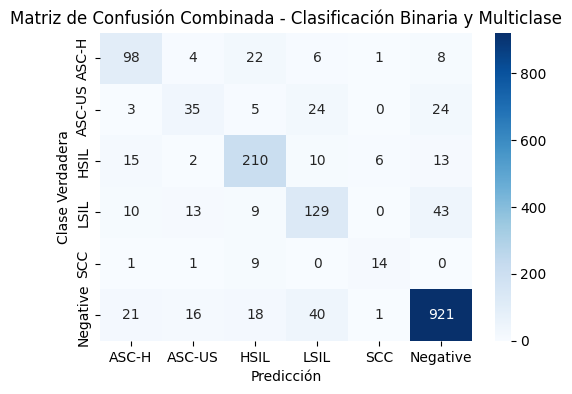

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lesion_classes = class_labels + ['Negative']

# Dividir en dos grupos: imágenes clasificadas como "Lesión" (1) y "No Lesión" (0)
lesion_indices = np.where(binary_predictions == 1)[0]
no_lesion_indices = np.where(binary_predictions == 0)[0]

# Preparar listas para las etiquetas verdaderas y predichas en la matriz de confusión combinada
y_true_combined = []
y_pred_combined = []

# Paso 1: Clasificar imágenes de "Lesión" con el modelo de 5 clases
for i in lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))  # Obtener clase verdadera desde el path
    true_class_index = lesion_classes.index(true_class_name)  # Índice de la clase verdadera

    # Procesar la imagen para el modelo multiclase
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción con el modelo de 5 clases
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Agregar a la lista de etiquetas combinadas
    y_true_combined.append(true_class_index)
    y_pred_combined.append(predicted_class)

# Paso 2: Asignar los verdaderos negativos y falsos negativos
for i in no_lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))
    if true_class_name == "Negative":
        # Verdadero negativo: era "Negative" y el modelo lo clasificó como "Negative"
        y_true_combined.append(lesion_classes.index("Negative"))
        y_pred_combined.append(lesion_classes.index("Negative"))
    else:
        # Falso negativo: era una lesión, pero se clasificó como "Negative" en la primera etapa
        true_class_index = lesion_classes.index(true_class_name)
        y_true_combined.append(true_class_index)
        y_pred_combined.append(lesion_classes.index("Negative"))

# Crear y visualizar la matriz de confusión combinada
cm_combined = confusion_matrix(y_true_combined, y_pred_combined)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes) 
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Combinada - Clasificación Binaria y Multiclase')
plt.show()

**Matriz de confusión final con escala ajustada**

Limitamos el valor máximo de la escala a un cuarto del valor más alto en la matriz para equilibrar el color y hacer que los errores y aciertos de las clases de lesiones sean más visibles frente al alto número de verdaderos negativos.

1/1 [==============================] - 0s 57ms/step


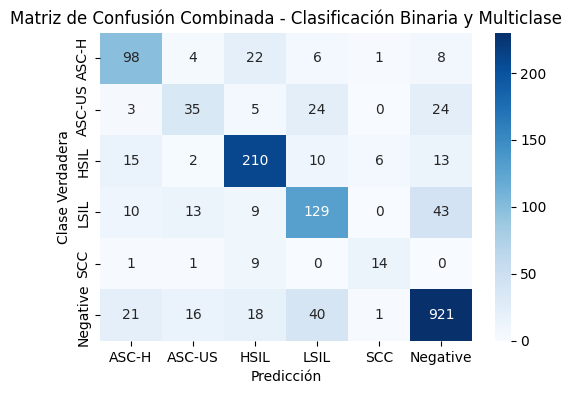

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lesion_classes = class_labels + ['Negative']

# Dividir en dos grupos: imágenes clasificadas como "Lesión" (1) y "No Lesión" (0)
lesion_indices = np.where(binary_predictions == 1)[0]
no_lesion_indices = np.where(binary_predictions == 0)[0]

# Preparar listas para las etiquetas verdaderas y predichas en la matriz de confusión combinada
y_true_combined = []
y_pred_combined = []

# Paso 1: Clasificar imágenes de "Lesión" con el modelo de 5 clases
for i in lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))  # Obtener clase verdadera desde el path
    true_class_index = lesion_classes.index(true_class_name)  # Índice de la clase verdadera

    # Procesar la imagen para el modelo multiclase
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Realizar la predicción con el modelo de 5 clases
    multi_class_pred = five_classes_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]

    # Agregar a la lista de etiquetas combinadas
    y_true_combined.append(true_class_index)
    y_pred_combined.append(predicted_class)

# Paso 2: Asignar los verdaderos negativos y falsos negativos
for i in no_lesion_indices:
    img_path = test_generator.filepaths[i]
    true_class_name = os.path.basename(os.path.dirname(img_path))
    if true_class_name == "Negative":
        # Verdadero negativo: era "Negative" y el modelo lo clasificó como "Negat
        # ive"
        y_true_combined.append(lesion_classes.index("Negative"))
        y_pred_combined.append(lesion_classes.index("Negative"))
    else:
        # Falso negativo: era una lesión, pero se clasificó como "Negative" en la primera etapa
        true_class_index = lesion_classes.index(true_class_name)
        y_true_combined.append(true_class_index)
        y_pred_combined.append(lesion_classes.index("Negative"))

# Crear y visualizar la matriz de confusión combinada
cm_combined = confusion_matrix(y_true_combined, y_pred_combined)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes, 
            vmax=np.max(cm_combined) // 4) 
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión Combinada - Clasificación Binaria y Multiclase')
plt.show()


In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, classification_report
import pandas as pd

# Define lesion classes
lesion_classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'SCC', 'Negative']

# Convert true labels to one-hot encoding for ROC calculation
num_classes = len(lesion_classes)
y_true_combined_one_hot = tf.keras.utils.to_categorical(y_true_combined, num_classes=num_classes)

# Prepare probabilities for each class in `y_pred_combined`
y_pred_combined_proba = np.zeros((len(y_pred_combined), num_classes))
for i, pred in enumerate(y_pred_combined):
    y_pred_combined_proba[i, pred] = 1

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_combined_one_hot[:, i], y_pred_combined_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves
# plt.figure(figsize=(10, 8))
# colors = cycle(['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan'])
# for i, color in zip(range(num_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {lesion_classes[i]} (area = {roc_auc[i]:.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves - Multi-Class Classification')
# plt.legend(loc="lower right")
# plt.show()

# Generate Classification Report
report = classification_report(y_true_combined, y_pred_combined, target_names=lesion_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Format all numeric columns in report_df to two decimal places
report_df = report_df.copy()
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.2f}")
report_df['support'] = report_df['support'].astype(int)  # Ensure 'support' column has no decimals



from tabulate import tabulate

# Display the Classification Report
print("Multi-Class Classification Report:")
print(tabulate(report_df, headers='keys', tablefmt='pretty', showindex=True))


Multi-Class Classification Report:
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|    ASC-H     |   0.66    |  0.71  |   0.68   |   139   |
|    ASC-US    |   0.49    |  0.38  |   0.43   |   91    |
|     HSIL     |   0.77    |  0.82  |   0.79   |   256   |
|     LSIL     |   0.62    |  0.63  |   0.62   |   204   |
|     SCC      |   0.64    |  0.56  |   0.60   |   25    |
|   Negative   |   0.91    |  0.91  |   0.91   |  1017   |
|   accuracy   |   0.81    |  0.81  |   0.81   |    0    |
|  macro avg   |   0.68    |  0.67  |   0.67   |  1732   |
| weighted avg |   0.81    |  0.81  |   0.81   |  1732   |
+--------------+-----------+--------+----------+---------+
